In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

Goal: 

0) Create a synthetic dataset where the data is $LogNormal(\mu, \sigma)$, with $\mu = f(x)$ and $f(x)$ some pre-defined positive function. We wish to see if standard GP regression performs as well as the LogNormal based GP.

1) Recover the latent function f(x) that models the parameter $\mu$ in the Normal likelihood, so we can find the expectation value of the distribution modelling the data, $\mu$, and the variance.

2) Recover the latent function g(x) that models the parameter $\mu$ in the LogNormal likelihood, so we can find the expectation value of the distribution modelling the data, $\exp (\mu + \sigma^2 / 2)$, and the variance.

3) Compare both expectation values (the one from the Normal likelihood and the one from the LogNormal likelihood)

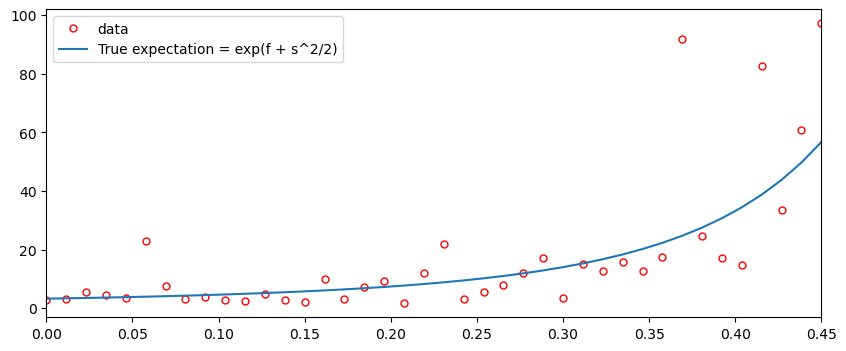

In [2]:
#Creating sythetic data for y ~ LogNorm(mu, sigma); mu = f(x) = exp(rate * x)
xmin = 0
xmax = 0.45
num_data_pts = 40
rate = 3.0
sigma = 0.6
loc = 0.0

grid = np.linspace(xmin, xmax, num_data_pts)
dx = float(grid[1]-grid[0])
f = lambda x : np.exp(rate * x)
E_y = lambda mu, sigma : np.exp(mu + sigma**2 / 2)
obs = np.random.lognormal(mean=f(grid), sigma=sigma)

plt.figure(figsize=(10, 4))
plt.plot(grid, obs, 'o', markersize=5, color='red', fillstyle = 'none', label='data')
plt.plot(grid, E_y(f(grid), sigma), label= "True expectation = exp(f + s^2/2)")
plt.xlim(xmin, xmax)
plt.legend()

In [39]:
#We fix the GP parameters
magnitude = 15.0
lengthscale = 1.
nu = 5/2
observation_noise = 1.

#Standard GP regression
kernel =  magnitude * Matern(length_scale=lengthscale, length_scale_bounds='fixed', nu=nu) 
gp_sklearn = GaussianProcessRegressor(kernel, alpha=observation_noise)
gp_sklearn.fit(grid.reshape(-1,1), obs.reshape(-1,1))
m_sklearn = gp_sklearn.predict(grid.reshape(-1,1)) #package prediction

K = gp_sklearn.kernel_(grid.reshape(-1,1), grid.reshape(-1,1))
mu_std_GP = loc + K @ np.linalg.inv(K + observation_noise * np.eye(len(grid))) @ (obs - loc) #custom prediction

#Log-Normal Score-based GP
"""magnitude = 10.
lengthscale = 0.1
nu = 5/2
observation_noise = 2."""

J_inv = np.diag(2 * (1/ np.sqrt(observation_noise) / obs)**2)
J = np.linalg.inv(J_inv)
del_y_ln_J_inv = -2 / obs
m_w = loc + observation_noise * del_y_ln_J_inv * obs
mu_log_GP = loc + K @ np.linalg.inv(K + observation_noise * J) @ (np.log(obs) - loc)


/opt/miniconda3/envs/TemporalGPs/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


(0.0, 0.45)

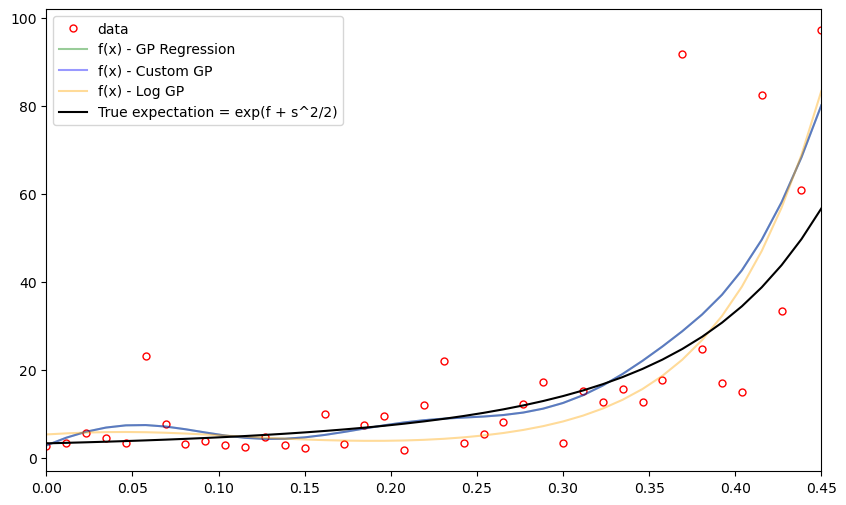

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(grid, obs, 'o', markersize=5, color='red', fillstyle = 'none', label='data')
plt.plot(grid, m_sklearn, '-', color='green', alpha=0.4, label = "f(x) - GP Regression")
plt.plot(grid, mu_std_GP, '-', color='blue', alpha=0.4, label = "f(x) - Custom GP")
plt.plot(grid, E_y(mu_log_GP, observation_noise), '-', color='orange', alpha=0.4, label = "f(x) - Log GP")
plt.plot(grid, E_y(f(grid), sigma), color='black', label= "True expectation = exp(f + s^2/2)")

plt.legend()
plt.xlim(xmin ,xmax)

In [16]:
magnitude = 1.0
lengthscale = 2
nu = 3/2
observation_noise = 0.5

kernel =  magnitude * Matern(length_scale=lengthscale, length_scale_bounds='fixed', nu=nu) 

gp_sklearn = GaussianProcessRegressor(kernel, alpha=observation_noise)

gp_sklearn.fit(grid.reshape(-1,1), obs.reshape(-1,1))

m_sklearn = gp_sklearn.predict(grid.reshape(-1,1))

K = gp_sklearn.kernel_(grid.reshape(-1,1), grid.reshape(-1,1))

mu_std_GP = loc + K @ np.linalg.inv(K + observation_noise * np.eye(len(grid))) @ (obs - loc)

mu_test_GP = loc + K @ np.linalg.inv(K + observation_noise * np.eye(len(grid))) @ (np.log(obs) - loc)

(0.0, 1.0)

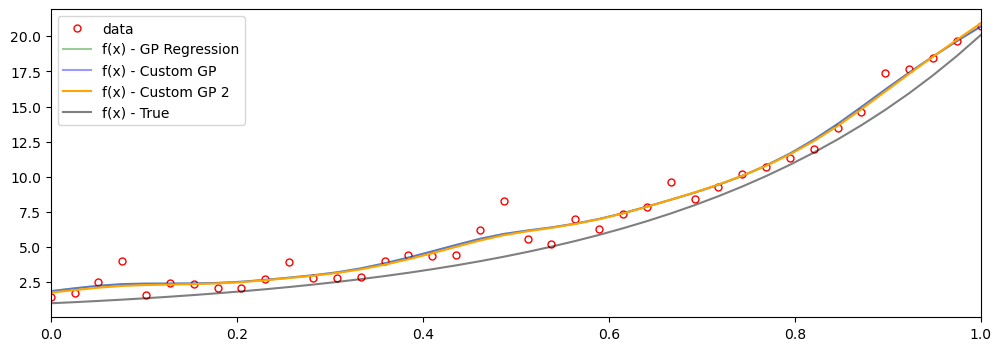

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(grid, obs, 'o', markersize=5, color='red', fillstyle = 'none', label='data')
plt.plot(grid, m_sklearn, '-', color='green', alpha=0.4, label = "f(x) - GP Regression")
plt.plot(grid, mu_std_GP, '-', color='blue', alpha=0.4, label = "f(x) - Custom GP")
plt.plot(grid, np.exp(mu_test_GP), '-', color='orange', alpha=1., label = "f(x) - Custom GP 2")

plt.plot(grid, f(grid), '-', color='black', alpha=0.5, label="f(x) - True")
plt.legend()
plt.xlim(xmin ,xmax)

In [23]:
beta = 1
c = 1
IMQ = lambda y, mu : beta * (1 + (y - mu)**2 / c**2)**(-1/2)

#w = IMQ(obs, 0)
w = 1
J_inv = np.diag(2 * (w/ np.sqrt(observation_noise) / obs)**2)
J_inv_ = np.diag(w/obs**2/observation_noise)

J = np.linalg.inv(J_inv)
J_ = np.linalg.inv(J_inv_)

magnitude_log = 20.
lengthscale_log = 0.5
observation_noise = 0.1

kernel =  magnitude_log * Matern(length_scale=lengthscale_log, length_scale_bounds='fixed', nu=nu) 

K = kernel(grid.reshape(-1,1), grid.reshape(-1,1))


del_y_J_inv = -2 / obs
m_w = loc + observation_noise * del_y_J_inv * obs
mu_log_GP = loc + K @ np.linalg.inv(K + observation_noise * J) @ (np.log(obs) - m_w)

(0.0, 1.0)

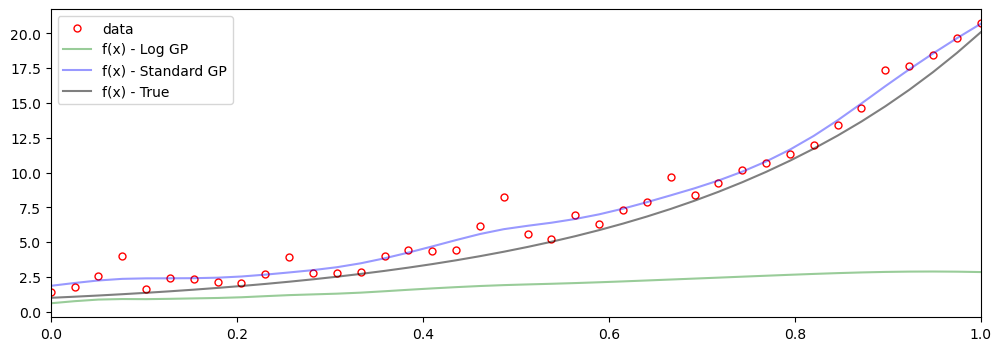

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(grid, obs, 'o', markersize=5, color='red', fillstyle = 'none', label='data')
plt.plot(grid, mu_log_GP, '-', color='green', alpha=0.4, label = "f(x) - Log GP")
plt.plot(grid, mu_std_GP, '-', color='blue', alpha=0.4, label = "f(x) - Standard GP")
plt.plot(grid, f(grid), '-', color='black', alpha=0.5, label="f(x) - True")
plt.legend()
plt.xlim(xmin ,xmax)